# IAQ and Fitbit-Measured Sleep Exploration
Arguably the main attraction (for me at least), we explore the effect of IAQ parameters on Fitbit-measured sleep parameters.

In [36]:
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Nightly Pollutant Exposures and Sleep Quality
The purpose of this notebook is to look at the in-depth relationships between IAQ and sleep quality, some of which has already been looked at in another notebook which has been copied here.

In [37]:
import os
import sys
sys.path.append('../')

from src.visualization import visualize

import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

import math
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import matplotlib.dates as mdates
from joypy import joyplot

import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats

# Data Import
For this analysis we need all reports of sleep quality in addition to the IEQ data and ventilation rates

### Fitbit Sleep Summary

In [38]:
fb_sleep = pd.read_csv("../data/processed/fitbit-sleep_summary-ux_s20.csv",parse_dates=["start_time","end_time","start_date","end_date"],infer_datetime_format=True)#,index_col=["beiwe","start_time"])
for stage in ["rem","nrem"]:
    fb_sleep[f"{stage}_percent"] = fb_sleep[f"{stage}_minutes"] / (fb_sleep["tst_fb"]*60)
fb_sleep.head()

,start_date,end_date,deep_count,deep_minutes,light_count,light_minutes,rem_count,rem_minutes,wake_count,wake_minutes,beiwe,efficiency,end_time,start_time,redcap,beacon,nrem_count,nrem_minutes,rem2nrem,tst_fb,rem_percent,nrem_percent,light_percent,deep_percent,waso,sol_fb,wol_fb
0,2020-05-14,2020-05-14,5.0,84.0,20.0,213.0,10.0,82.0,21.0,27.0,hfttkth7,93.349754,2020-05-14 07:13:00,2020-05-14 00:27:00,NaN,NaN,25.0,297.0,0.276094,6.316667,0.216359,0.783641,0.562005,0.221636,18.5,8.5,0.0
1,2020-05-14,2020-05-15,4.0,95.0,31.0,250.0,6.0,47.0,33.0,101.0,hfttkth7,79.513185,2020-05-15 08:06:30,2020-05-14 23:53:30,NaN,NaN,35.0,345.0,0.136232,6.533333,0.119898,0.880102,0.637755,0.242347,68.5,0.0,32.5
2,2020-05-15,2020-05-16,2.0,47.0,17.0,190.0,8.0,50.0,20.0,42.0,hfttkth7,87.234043,2020-05-16 04:57:00,2020-05-15 23:28:00,NaN,NaN,19.0,237.0,0.210970,4.783333,0.174216,0.825784,0.662021,0.163763,19.5,11.5,11.0
3,2020-05-17,2020-05-17,5.0,78.0,21.0,242.0,11.0,83.0,25.0,44.0,hfttkth7,90.156600,2020-05-17 09:28:30,2020-05-17 02:01:30,NaN,NaN,26.0,320.0,0.259375,6.716667,0.205955,0.794045,0.600496,0.193548,23.0,12.5,8.5
4,2020-05-18,2020-05-18,5.0,96.0,20.0,167.0,14.0,88.0,28.0,65.0,hfttkth7,84.375000,2020-05-18 07:20:00,2020-05-18 00:24:00,NaN,NaN,25.0,263.0,0.334601,5.850000,0.250712,0.749288,0.475783,0.273504,53.5,11.5,0.0


In [39]:
len(fb_sleep["beiwe"].unique())

56

### Self-Report Sleep

In [40]:
beiwe_sleep = pd.read_csv("../data/processed/beiwe-morning_ema-ux_s20.csv",parse_dates=["timestamp"],infer_datetime_format=True)
beiwe_sleep.head()

,timestamp,beiwe,content,stress,lonely,sad,energy,tst,sol,naw,restful,redcap,beacon
0,2020-05-13 09:10:27,qh34m4r9,3,0.0,0.0,0.0,1.0,8.0,20.0,2.0,3.0,68,19.0
1,2020-05-13 09:15:49,awa8uces,0.0,2.0,1.0,1.0,1.0,2.0,10.0,3.0,1.0,28,26.0
2,2020-05-13 09:42:19,xxvnhauv,1,1.0,1.0,3.0,0.0,6.0,30.0,3.0,1.0,21,22.0
3,2020-05-13 09:43:27,rvhdl2la,1,1.0,2.0,3.0,0.0,5.3,5.0,2.0,2.0,29,NaN
4,2020-05-13 10:11:51,q5y11ytm,3,1.0,0.0,1.0,2.0,2.0,10.0,0.0,0.0,48,NaN


### Beacon IAQ
IAQ measurements courtesy of the beacons

In [41]:
ieq_raw = pd.read_csv("../data/processed/beacon_by_night-ux_s20.csv",parse_dates=["start_time","end_time",],infer_datetime_format=True)
ieq_raw = ieq_raw[(ieq_raw["home"] == 1) | (ieq_raw["increasing_co2"] > 0.5)]
ieq_raw = ieq_raw.groupby(["beacon","beiwe","redcap","start_time","end_time"]).median()
ieq_raw = ieq_raw.add_suffix("_median")
ieq_raw.reset_index(inplace=True)
ieq_raw.dropna(subset=["tvoc_median","co_median","co2_median","pm2p5_mass_median"],how="all",inplace=True)
ieq_ema_raw = ieq_raw[ieq_raw["ema_median"] == 1]
ieq_raw.drop(["home_median","increasing_co2_median","ema_median","no2_median"],axis="columns",inplace=True)
ieq_ema_raw.drop(["home_median","increasing_co2_median","ema_median","no2_median"],axis="columns",inplace=True)
ieq = ieq_raw.copy()
ieq_ema = ieq_ema_raw.copy()
ieq.head()

,beacon,beiwe,redcap,start_time,end_time,tvoc_median,lux_median,co_median,co2_median,pm1_number_median,pm2p5_number_median,pm10_number_median,pm1_mass_median,pm2p5_mass_median,pm10_mass_median,temperature_c_median,rh_median
0,1,kyj367pi,10,2020-06-10 23:05:00,2020-06-11 09:14:00,63.508824,0.0,0.000000e+00,607.609765,7.322099,7.641275,27.572210,0.456075,16.515731,1.898475,17.359939,39.483333
1,1,kyj367pi,10,2020-06-11 23:12:30,2020-06-12 09:14:30,225.128039,0.0,0.000000e+00,630.040491,14.058337,13.393014,62.818538,0.892219,34.128077,2.004953,16.455691,40.436667
2,1,kyj367pi,10,2020-06-17 22:55:30,2020-06-18 08:51:30,339.356742,0.0,9.251859e-19,616.201568,10.731803,10.305398,43.552369,0.656736,20.605142,1.909191,16.615442,45.706667
3,1,kyj367pi,10,2020-06-18 22:13:30,2020-06-19 08:42:00,327.725941,0.0,0.000000e+00,598.332358,10.976217,10.498097,44.709340,0.671372,20.834074,1.908418,18.173762,46.830000
4,1,kyj367pi,10,2020-06-20 23:06:30,2020-06-21 07:43:00,336.387886,0.0,0.000000e+00,585.162549,8.196889,8.283711,31.361368,0.504261,15.928621,1.884694,17.359939,47.862500


In [42]:
print(f"Beacons ({len(ieq['beacon'].unique())}): {ieq['beacon'].unique()}")

Beacons (20): [ 1  5  6  7 10 11 15 16 19 21 24 25 26 29 30 34 36 38 44 46]


In [43]:
gps = pd.read_csv("../data/processed/beiwe-gps-ux_s20.csv")
gps.head()

,timestamp,utc,lat,long,altitude,accuracy,beiwe
0,2020-05-06 01:00:00,2020-05-06T06:00:05.477,30.23705,-97.71051,135.77695,65.00000,15tejjtw
1,2020-05-06 02:05:00,2020-05-06T07:05:39.725,30.23706,-97.71049,135.84357,65.00000,15tejjtw
2,2020-05-06 02:06:00,2020-05-06T07:06:06.808,30.23706,-97.71049,135.84357,65.00000,15tejjtw
3,2020-05-06 03:01:00,2020-05-06T08:01:07.179,30.23716,-97.71047,139.34561,64.00967,15tejjtw
4,2020-05-06 03:02:00,2020-05-06T08:02:00.546,30.23716,-97.71047,139.34561,32.00483,15tejjtw


In [44]:
gps_inspection = gps.merge(right=ieq,on=["beiwe"])
len(gps_inspection["beiwe"].unique())

19

<div class="alert alert-block alert-warning">
 
**One** participant that we use in the analysis did not provide and GPS data.
    
</div>

### Beacon Ventilation Estimates
CO2-based ventilation rates

In [45]:
aer = pd.read_csv("../data/processed/beacon-ventilation.csv",parse_dates=["start","end"],infer_datetime_format=True)
aer["end_date"] = pd.to_datetime(aer["end"].dt.date)
aer.head()

,beacon,beiwe,start,end,ach,method,end_date
0,46.0,nvtfpaor,2020-07-18 12:42:00,2020-07-18 13:18:00,0.028,decay,2020-07-18
1,46.0,nvtfpaor,2020-07-18 15:00:00,2020-07-18 15:38:00,0.054,decay,2020-07-18
2,46.0,nvtfpaor,2020-07-24 11:24:00,2020-07-24 12:14:00,0.025,decay,2020-07-24
3,46.0,nvtfpaor,2020-07-24 13:06:00,2020-07-24 14:20:00,0.022,decay,2020-07-24
4,46.0,nvtfpaor,2020-08-14 12:50:00,2020-08-14 13:26:00,0.093,decay,2020-08-14


# Fitbit-Measured Sleep
We start by looking at the response in Fitbit-measure sleep metrics

In [46]:
sleep_metrics = ["efficiency","rem2nrem","tst_fb","waso","rem_percent","nrem_percent"]
ieq_and_fb_sleep = ieq.merge(right=fb_sleep,on=["start_time","end_time","beiwe","redcap","beacon"],how='inner', indicator=False)
ieq_and_fb_sleep = ieq_and_fb_sleep[[column for column in ieq_and_fb_sleep.columns if not column.endswith("delta")]]

## Summary of Available Data
We just look at a few key values from the merged dataset.

In [47]:
print("Number of Observations:", len(ieq_and_fb_sleep))

Number of Observations: 488


In [48]:
count = 0
for pt in ieq_and_fb_sleep["beiwe"].unique():
    print(f"{pt}:\t{len(ieq_and_fb_sleep[ieq_and_fb_sleep['beiwe'] == pt])}")
    count += len(ieq_and_fb_sleep[ieq_and_fb_sleep['beiwe'] == pt])
    
print(count)

kyj367pi:	26
745vq78e:	16
itmylz3g:	26
zdpffrox:	22
xlw5ntd5:	13
i31pt4b4:	23
9jtzsuu8:	25
e73a1pd5:	3
qh34m4r9:	48
lkkjddam:	51
xdbdrk6e:	11
vr9j5rry:	40
awa8uces:	27
tmexej5v:	43
idbkjh8u:	5
rnse61g4:	5
tlmlq19s:	69
olaxadz5:	25
4i7679py:	6
nvtfpaor:	4
488


In [49]:
ieq_and_fb_sleep["beiwe"].value_counts()

tlmlq19s    69
lkkjddam    51
qh34m4r9    48
tmexej5v    43
vr9j5rry    40
awa8uces    27
kyj367pi    26
itmylz3g    26
olaxadz5    25
9jtzsuu8    25
i31pt4b4    23
zdpffrox    22
745vq78e    16
xlw5ntd5    13
xdbdrk6e    11
4i7679py     6
idbkjh8u     5
rnse61g4     5
nvtfpaor     4
e73a1pd5     3
Name: beiwe, dtype: int64

In [50]:
ieq_and_fb_sleep[ieq_and_fb_sleep["beiwe"] == "tlmlq19s"]

,beacon,beiwe,redcap,start_time,end_time,tvoc_median,lux_median,co_median,co2_median,pm1_number_median,pm2p5_number_median,pm10_number_median,pm1_mass_median,pm2p5_mass_median,pm10_mass_median,temperature_c_median,rh_median,start_date,end_date,deep_count,deep_minutes,light_count,light_minutes,rem_count,rem_minutes,wake_count,wake_minutes,efficiency,nrem_count,nrem_minutes,rem2nrem,tst_fb,rem_percent,nrem_percent,light_percent,deep_percent,waso,sol_fb,wol_fb
384,36,tlmlq19s,47,2020-06-18 00:41:30,2020-06-18 09:07:30,360.240851,0.000000e+00,1.497786,1132.266912,4.776011,5.244516,21.529328,0.424301,11.453546,2.132867,24.855975,37.486667,2020-06-18,2020-06-18,2.0,91.0,25.0,253.0,10.0,94.0,31.0,68.0,86.561265,27.0,344.0,0.273256,7.300000,0.214612,0.785388,0.577626,0.207763,49.5,5.5,13.0
385,36,tlmlq19s,47,2020-06-19 01:02:30,2020-06-19 08:02:00,258.611794,0.000000e+00,0.178302,931.606994,6.910497,7.429648,24.394913,0.559043,13.176838,2.254382,24.855975,38.603333,2020-06-19,2020-06-19,4.0,88.0,21.0,189.0,17.0,104.0,29.0,38.0,90.930788,25.0,277.0,0.375451,6.350000,0.272966,0.727034,0.496063,0.230971,33.5,4.5,0.0
386,36,tlmlq19s,47,2020-06-20 23:11:00,2020-06-21 09:18:00,71.531182,0.000000e+00,0.000000,584.071172,5.221514,6.041097,22.615977,0.474099,12.610691,2.233171,24.838949,37.938889,2020-06-20,2020-06-21,5.0,82.0,35.0,347.0,16.0,88.0,42.0,90.0,85.172982,40.0,429.0,0.205128,8.616667,0.170213,0.829787,0.671180,0.158607,90.0,0.0,0.0
387,36,tlmlq19s,47,2020-06-22 00:03:00,2020-06-22 07:37:00,308.519693,0.000000e+00,0.012553,877.197324,7.270339,8.017757,25.213914,0.595754,14.458021,2.375965,24.855975,39.613333,2020-06-22,2020-06-22,4.0,106.0,24.0,182.0,22.0,126.0,38.0,40.0,91.189427,28.0,288.0,0.437500,6.900000,0.304348,0.695652,0.439614,0.256039,31.0,9.0,0.0
388,36,tlmlq19s,47,2020-06-23 23:56:30,2020-06-24 07:45:00,365.334097,0.000000e+00,0.482662,939.844287,1.688566,2.265625,17.528063,0.236916,9.496766,2.008038,23.703927,36.143333,2020-06-23,2020-06-24,2.0,116.0,21.0,181.0,15.0,118.0,32.0,53.0,88.675214,23.0,297.0,0.397306,6.916667,0.284337,0.715663,0.436145,0.279518,53.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448,36,tlmlq19s,47,2020-08-30 23:42:30,2020-08-31 07:26:00,13.649851,1.480297e-17,0.000000,634.841645,16.217220,16.413724,36.071167,1.110450,18.517417,2.606521,23.331913,44.200000,2020-08-30,2020-08-31,3.0,67.0,28.0,286.0,9.0,40.0,35.0,70.0,84.881210,31.0,353.0,0.113314,6.550000,0.101781,0.898219,0.727735,0.170483,64.5,0.0,5.5
449,36,tlmlq19s,47,2020-09-01 00:10:00,2020-09-01 06:59:00,269.353277,0.000000e+00,0.000000,705.238342,30.614872,30.102061,53.790747,1.951972,26.660680,3.117623,26.263403,47.035556,2020-09-01,2020-09-01,4.0,70.0,29.0,217.0,10.0,65.0,33.0,57.0,86.063570,33.0,287.0,0.226481,5.866667,0.184659,0.815341,0.616477,0.198864,57.0,0.0,0.0
450,36,tlmlq19s,47,2020-09-01 23:15:00,2020-09-02 07:49:30,119.915942,0.000000e+00,0.000000,663.676090,23.698259,24.264266,46.402345,1.593432,25.314300,3.108679,26.223677,47.193333,2020-09-01,2020-09-02,2.0,83.0,29.0,279.0,9.0,56.0,36.0,96.0,81.322957,31.0,362.0,0.154696,6.966667,0.133971,0.866029,0.667464,0.198565,86.5,0.0,9.5
451,36,tlmlq19s,47,2020-09-03 23:24:00,2020-09-04 08:10:30,330.801031,0.000000e+00,0.000000,1085.883453,6.359062,7.179247,24.159288,0.545154,14.071746,2.341806,25.690216,48.391667,2020-09-03,2020-09-04,2.0,99.0,30.0,281.0,9.0,66.0,36.0,80.0,84.790875,32.0,380.0,0.173684,7.433333,0.147982,0.852018,0.630045,0.221973,72.0,8.0,0.0


In [51]:
print("Number of Participants:", len(ieq_and_fb_sleep["beiwe"].unique()))

Number of Participants: 20


In [52]:
def plot_data_availability_heatmap(df, df_filter='not', agg_str = "", save=False, save_dir='../reports/figures/'):
    '''
    Plots a heatmap showing number of nights the various beacons measured for each sensor
    
    Inputs
    - df: dataframe with columns in columns_to_use
    - df_filter: the naming convention of the filtering applied to the beacon - used when saving
    - savefig: boolean specifying whether or not to save the file
    - save_dir: string of the location to save the figure
    
    Returns the count dataframe used to generate the heatmap
    '''
    # filtering the dataframe to only include import vars
    var_list = ['lux','tvoc','co2','co','pm2p5_mass']
    columns_to_use = [column + agg_str for column in var_list] + ['beacon','start_time']
    df_filtered = df.copy()[columns_to_use]
    # dict to store the values
    data = {f'lux{agg_str}':[],f'tvoc{agg_str}':[],f'co2{agg_str}':[],f'co{agg_str}':[],f'pm2p5_mass{agg_str}':[],'beacon':[]}
    # looping through the dataframe to get the number of nights each beacon measured
    for bb in df_filtered['beacon'].unique():
        df_by_bb_by_night = df_filtered[df_filtered['beacon'] == bb]
        for var in columns_to_use:
            if var == "start_time":
                pass
            elif var == 'beacon':
                data['beacon'].append(bb)
            else:
                data[var].append(df_by_bb_by_night.count()[var])

    # formatting dataframe
    df_count = pd.DataFrame(data=data,index=data['beacon'])
    df_count.drop('beacon',axis=1,inplace=True)
    df_count.sort_index(inplace=True)
    
    # plotting heatmap
    fig, ax = plt.subplots(figsize=(12,5))
    sns.heatmap(df_count.sort_values(by=f'lux{agg_str}').T,square=True,annot=True,fmt="d",linewidths=.5,cmap="Blues",vmin=0,vmax=70,cbar_kws={"shrink":0.5,"pad":0.02,"ticks":[0,10,20,30,40,50,60,70]},ax=ax)
    # reformatting figure labels
    ax.set_yticklabels(['Light','TVOC','CO$_2$','CO','PM$_{2.5}$'],rotation=0)
    ax.set_xlabel('Beacon Number')
    #ax.set_title('Number of Nights Measured by BEVO Beacon')
    
    # saving and showing
    if save:
        plt.savefig(f'{save_dir}beacon_{df_filter}_filtered-data_availability-heatmap-ux_s20.pdf',bbox_inches='tight')
    plt.show()
    plt.close()
    
    return df_count

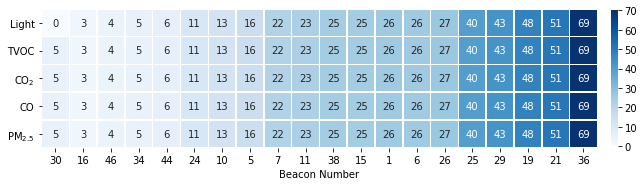

In [53]:
temp = plot_data_availability_heatmap(ieq_and_fb_sleep, agg_str="_median",save=False)

## Grouping Nights by Concentration
We can group each of the nights based on the median concentration value for each pollutant can compare that to sleep quality. However, to do so requires that we establish thresholds for low and high concentrations:
- **TVOCs**: The "short and long-term" [recommendation by the WHO](https://iaqscience.lbl.gov/voc-intro) is 100 ppb so `tvoc_threshold=100`
- **NO$_2$**: EPA provides outdoor standards where the most strict standard is the annual exposure limit at 53 ppb. The EPA's [discussion on indoor](https://www.epa.gov/indoor-air-quality-iaq/nitrogen-dioxides-impact-indoor-air-quality) NO$_2$ states that indoor concentration "[are] about half that of outdoors." Therefore, we will set `no2_threshold=25`. 
- **CO**: The WHO published a [study on CO guidelines](https://www.ncbi.nlm.nih.gov/books/NBK138710/) and recommended as low as 7 mg/m$^3$ which is approximately 6 ppm so `co_threshold=6`
- **CO$_2$**: [OSHA](https://ohsonline.com/Articles/2016/04/01/Carbon-Dioxide-Detection-and-Indoor-Air-Quality-Control.aspx?m=1&Page=2) and ASHRAE generally agree that concentrations above 1100 ppm tend to create some issues so `co2_threshold=1100`
- **PM2.5** (mass): Considering the EPA again, the outdoor annual exposure limit is 12 $\mu$g/m$^3$ and the [EPA mentions](https://www.epa.gov/indoor-air-quality-iaq/indoor-particulate-matter#Levels_in_Homes) that concentrations indoors would mirror outdoor concentrations absent of any indoor sources. However, that threshold is still too high so we use the median concentration from the study: `pm2p5_mass_threshold=1.5`
- **Temperature**: The ideal temperature range is between 60-67F which is lower than the minimum temperature that was measured. So we will use 27/80.6 (median temperature from the study) as a lower threshold and then increase slightly for the extra heat from the sensors so `temperature_c_threshold=27`.

### Visualizing and Running T-Test on Sleep Metrics
Now we can look at the distribution of sleep metrics for each pollutant profile and run a T-Test to see if there are _significant_ differences between the sleep metric results.

In [54]:
def run_ttest_ieq_and_sleep(df, pollutants=["tvoc","no2","co","co2","pm2p5_mass","temperature_c"], limits=[200,1.5,3.6,1100,6,27], sleep_device="fitbit", sleep_metrics=["tst_fb","efficiency","waso","rem2nrem"], pollutant_metric="median", showfig=True, save=False):
    """
    
    """
    df_to_plot = df.copy()
    # adding "low"/"high" column for each pollutant
    thresholds = dict(zip(pollutants,limits))
    for pollutant, threshold in thresholds.items():
        df_to_plot[f"{pollutant}_level"] = np.where(df_to_plot[f"{pollutant}_{pollutant_metric}"] < threshold, "low","high")
    # creating dictionary to store p-values
    ttest_results = {}
    # looping through sleep metrics
    for sleep_metric in sleep_metrics:
        print(f"Running for: {sleep_metric.split('_')[0]}")
        # expanding the df to allow for easier plotting
        df_expanded = df_to_plot.melt(id_vars=[c for c in df_to_plot.columns if c.endswith("median") or c == sleep_metric],value_vars=[c for c in df_to_plot.columns if c.endswith("level")],value_name="level")
        # plotting
        fig,ax = plt.subplots(figsize=(16,6))
        sns.violinplot(x="variable",y=sleep_metric,hue="level",data=df_expanded,split=True,hue_order=["low","high"],palette={"low":"white","high":"#bf5700"},inner="quartile",cut=0,ax=ax)
        # x-axis
        ax.set_xticklabels([pollutant.split("_")[0].upper().replace("O2","O$_2$").replace("2P5","$_{2.5}$").replace(" C","").replace("TEMPERATURE","T") for pollutant in pollutants],fontsize=14)
        ax.set_xlabel("")
        # y-axis
        plt.setp(ax.get_yticklabels(), ha="right", rotation=0, fontsize=14)
        if sleep_metric not in ["efficiency"]:
            ax.set_ylabel(sleep_metric.split("_")[0].replace("2",":").upper().replace("N","n"),fontsize=16)
        else:
            ax.set_ylabel(sleep_metric.title(),fontsize=16)
        # Modifying Remainder
        ax.legend(bbox_to_anchor=(1.1,0.75),frameon=False,ncol=1,fontsize=12,title_fontsize=14,title="Median\nConcentration")
        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)

        pvals = pd.DataFrame()
        for pollutant in pollutants:
            df = df_expanded[df_expanded["variable"] == f"{pollutant}_level"]
            low_vals = df[df["level"] == "low"]
            high_vals = df[df["level"] == "high"]
            _, p = stats.ttest_ind(low_vals[sleep_metric],high_vals[sleep_metric], equal_var=True)
            pvals = pvals.append(pd.DataFrame({"pollutant":[pollutant],"low":[len(low_vals)],"high":[len(high_vals)],"p_val":[p]}))

        ttest_results[sleep_metric.split("_")[0]] = pvals.set_index("pollutant")

        # Annotating with p-values
        xlocs = ax.get_xticks()
        ax.text(ax.get_xlim()[0],ax.get_ylim()[1],"          p:",ha="center",va="bottom",fontsize=12)
        for xloc, p in zip(xlocs,ttest_results[sleep_metric.split("_")[0]]["p_val"]):
            weight="bold" if p < 0.05 else "normal"
            val = round(p,3) if p > 0.001 else "< 0.001"
            ax.text(xloc,ax.get_ylim()[1],val,fontsize=12,ha="center",va="bottom",weight=weight)
            
        if save:
            plt.savefig(f'../../papers/5eea5276044b790001ee5687/figures/beacon-{sleep_device}-{pollutant_metric}_profile-{sleep_metric}-ux_s20.pdf',bbox_inches="tight")
            plt.savefig(f'../reports/figures/beacon_{sleep_device}/beacon-{sleep_device}-{pollutant_metric}_profile-{sleep_metric}-ux_s20.png',bbox_inches="tight")

        if showfig:
            plt.show()
            plt.close()
            
    return ttest_results
    

In [55]:
def get_night(val,threshold):
    if math.isnan(val):
        return np.nan
    elif val < threshold:
        return "low"
    else:
        return "high"

In [56]:
def plot_fb_sq_violins(df, pollutants=["tvoc","no2","co","co2","pm2p5_mass","temperature_c"], limits=[200,1.5,4,1100,6,25.2], sleep_device="fitbit", sleep_metrics=["tst_fb","efficiency","waso","rem2nrem"], pollutant_metric="median", annot="all",save=False):
    """
    
    """
    legend_fs = 22
    tick_fs = 24
    label_fs = 26
    title_fs = 32
    df_to_plot = df.copy()
    # adding "low"/"high" column for each pollutant
    thresholds = dict(zip(pollutants,limits))
    for pollutant, threshold in thresholds.items():
        #df_to_plot[f"{pollutant}_level"] = np.where(df_to_plot[f"{pollutant}_{pollutant_metric}"] < threshold, "low","high")
        df_to_plot[f"{pollutant}_level"] = df_to_plot.apply(lambda x: get_night(x[f"{pollutant}_{pollutant_metric}"],threshold),axis=1)

    # creating dictionary to store p-values
    ttest_results = {}
    # looping through sleep metrics
    fig,axes = plt.subplots(len(sleep_metrics),1,figsize=(16,5*len(sleep_metrics)),sharex=True)
    try:
        _ = len(axes)
    except TypeError:
        axes = [axes]
    for sleep_metric, title, ax in zip(sleep_metrics,["a","b","c","d"],axes):
        # expanding the df to allow for easier plotting
        df_expanded = df_to_plot.melt(id_vars=[c for c in df_to_plot.columns if c.endswith("median") or c == sleep_metric],value_vars=[c for c in df_to_plot.columns if c.endswith("level")],value_name="level")
        # plotting
        sns.violinplot(x="variable",y=sleep_metric,hue="level",data=df_expanded,split=True,hue_order=["low","high"],palette={"low":"white","high":"#bf5700"},inner=None,cut=0,ax=ax)
        # x-axis
        ax.set_xticklabels([pollutant.split("_")[0].upper().replace("O2","O$_2$").replace("2P5","$_{2.5}$").replace(" C","").replace("TEMPERATURE","T") for pollutant in pollutants],fontsize=tick_fs)
        ax.set_xlabel("")
        # y-axis
        plt.setp(ax.get_yticklabels(), ha="right", rotation=0, fontsize=tick_fs)
        ax.set_ylabel(visualize.get_label(sleep_metric),fontsize=label_fs)
        # Modifying Remainder
        if sleep_metric == "rem2nrem":
            ax.legend(loc="upper center",bbox_to_anchor=(0.5,-0.075),frameon=False,ncol=2,fontsize=legend_fs,title_fontsize=tick_fs,title="Median Concentration")
        else:
            ax.get_legend().remove()
        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)
            
        ax.text(-0.075,0.95,title,fontsize=title_fs,transform=ax.transAxes)

        pvals = pd.DataFrame()
        for pollutant in pollutants:
            df = df_expanded[df_expanded["variable"] == f"{pollutant}_level"]
            low_vals = df[df["level"] == "low"]
            high_vals = df[df["level"] == "high"]
            #print(f"Number of high:\t{len(high_vals)}\nNumber of low:\t{len(low_vals)}")
            _, p = stats.ttest_ind(low_vals[sleep_metric],high_vals[sleep_metric], equal_var=True, nan_policy="omit")
            pvals = pvals.append(pd.DataFrame({"pollutant":[pollutant],"low":[len(low_vals)],"high":[len(high_vals)],
                                               "mean_low":[np.nanmean(low_vals[sleep_metric])],"mean_high":np.nanmean(high_vals[sleep_metric]),"p_val":[p]}))

        ttest_results[sleep_metric.split("_")[0]] = pvals.set_index("pollutant")

        # Annotating with p-values
        xlocs = ax.get_xticks()
        ax.text(ax.get_xlim()[0],ax.get_ylim()[1],"          p:",ha="center",va="bottom",fontsize=tick_fs)
        for xloc, p in zip(xlocs,ttest_results[sleep_metric.split("_")[0]]["p_val"]):
            weight="bold" if p < 0.05 else "normal"
            val = round(p,3) if p > 0.001 else "< 0.001"
            ax.text(xloc,ax.get_ylim()[1],val,fontsize=tick_fs,ha="center",va="bottom",weight=weight)
            
        if save:
            plt.savefig(f'../../papers/5eea5276044b790001ee5687/figures/beacon-{sleep_device}-{pollutant_metric}_profile-{annot}-ux_s20.pdf',bbox_inches="tight")
            plt.savefig(f'../reports/figures/beacon_{sleep_device}/beacon-{sleep_device}-{pollutant_metric}_profile-{annot}-ux_s20.pdf',bbox_inches="tight")

    plt.show()
    plt.close()
    
    return ttest_results
    

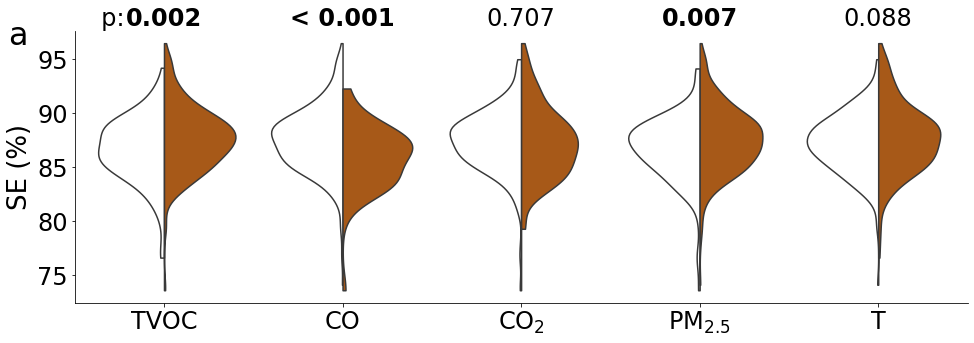

In [57]:
temp = plot_fb_sq_violins(ieq_and_fb_sleep,pollutants=["tvoc","co","co2","pm2p5_mass","temperature_c"],limits=[200,4,1100,6,25.2],sleep_metrics=["efficiency"],pollutant_metric="median",
                          annot="se",save=False)


In [97]:
temp

{'tst':                low  high  mean_low  mean_high     p_val
 pollutant                                              
 tvoc            65   192  6.884615   6.878646  0.973156
 co             236    21  6.865254   7.047619  0.516933
 co2            172    85  6.985465   6.667059  0.051185
 pm2p5_mass      55   202  6.654545   6.941584  0.125976
 temperature_c  129   116  7.141473   6.697845  0.003673}

In [59]:
(temp["efficiency"].loc["co2","mean_low"]) - (temp["efficiency"].loc["co2","mean_high"])

0.11012290154729953

In [60]:
(temp["efficiency"].loc["co","mean_low"]) - (temp["efficiency"].loc["co","mean_high"])

1.6931257786225586

In [61]:
(temp["efficiency"].loc["no2","mean_low"]) - (temp["efficiency"].loc["no2","mean_high"])

KeyError: 'no2'

In [ ]:
(temp["rem2nrem"].loc["tvoc","mean_low"] - temp["rem2nrem"].loc["tvoc","mean_high"]) / temp["rem2nrem"].loc["tvoc","mean_low"]

In [ ]:
#ttest_results = run_ttest_ieq_and_sleep(ieq_and_fb_sleep,save=False)

## Ventilation
Now we look at the relationship between ventilation and Fitbit-measured sleep metrics

### Merging Datasets
There are sometimes multiple ventilation rates per evening, but merging the datasets perserve these nights and duplicate the Fitbit measurements.

In [ ]:
aer_and_fb = aer.merge(right=fb_sleep,on=["beiwe","end_date"])
aer_and_fb.head()

In [ ]:
fig, axes = plt.subplots(1,len(sleep_metrics),figsize=(len(sleep_metrics)*6,6))
for sleep_metric, ax in zip(sleep_metrics, axes):
    sns.scatterplot(x="ach",y=sleep_metric,hue="method",data=aer_and_fb,
                    palette=["cornflowerblue","firebrick"],s=50,ax=ax)
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)
        
    
    ax.set_xlabel("ACH",fontsize=12)
    ax.set_ylabel(sleep_metric.split("_")[0].upper(),fontsize=12)

### Examining Distributions of Sleep Metrics Based on Low/High Ventilation Rates
We can parse out the ventilation rates into `low` and `high` values by looking at some of the recommendations given by ASHRAE standard 62.2. The standard recommends a ventilation rate of 0.35 ACH per person. Most, if not all of our participants, should be the only occupants of their bedrooms. Therefore, we can use the 0.35 ACH as our cutoff point between the distributions.

In [ ]:
def plot_binary_violin(df_in, yvar="tst_fb", binary_var="ventilation_quality", ylabel="Sleep Time (h)", save=False, save_dir="../reports/figures/beacon_fitbit"):
    """Plots violin plots of concentration distributions for positive and negative restfulness scores"""
    df = df_in.copy()
    fig, ax = plt.subplots(figsize=(6,6))
    df["target"] = yvar
    violin_axes = sns.violinplot(x="target",y=yvar,hue=binary_var,split=True,palette=["white","cornflowerblue"],data=df,ax=ax,cut=0,inner="quartile",)
    for loc in ["right","top","bottom"]:
        ax.spines[loc].set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.get_legend().remove()
    ax.set_ylabel(ylabel,fontsize=18)
    plt.yticks(fontsize=14)
    ax.legend(title="Ventilation Quality",ncol=1,frameon=False,title_fontsize=14,fontsize=12)

    low_vals = df[df[binary_var] == "Inadequate"]
    high_vals = df[df[binary_var] == "Adequate"]
    _, p = stats.ttest_ind(low_vals[yvar],high_vals[yvar], equal_var=True, nan_policy="omit")

    if p > 0:
        # Annotating with p-values
        xloc = ax.get_xticks()
        weight="bold" if p < 0.05 else "normal"
        ax.text(xloc-0.07,ax.get_ylim()[1],"p: ",fontsize=12,ha="center",va="bottom")
        ax.text(xloc,ax.get_ylim()[1],f"{round(p,3)}",fontsize=12,ha="center",va="bottom",weight=weight)

    if save:
        plt.savefig(f"{save_dir}/{yvar}-{binary_var}-violin.pdf", bbox_inches="tight")
        
    plt.show()
    plt.close()

In [ ]:
aer_and_fb["ventilation_quality"] = ["Adequate" if rate >= 0.35 else "Inadequate" for rate in aer_and_fb["ach"]]
for sleep_metric in sleep_metrics:
    plot_binary_violin(aer_and_fb, sleep_metric, ylabel=visualize.get_sleep_label(sleep_metric), save=False)

# Self-Report Sleep Metrics
Next, we see how the results change if we consider self-report sleep metrics.

## Pre-Processing
There are a few tweaks to the original dataset that we want to make.

### Removing Outlier
There are a few `sol` values that are uncharacteristically high

In [62]:
def remove_outlier(df, var, extreme="z",zscore=2.5):
    if extreme == "z":
        df['z'] = abs(df[var] - df[var].mean()) / df[var].std(ddof=0)
        df["outlier"] = df['z'] > zscore
    else:
        Q1 = df[var].quantile(0.25)
        Q3 = df[var].quantile(0.75)
        IQR = Q3 - Q1
        print("df")

        # Filtering Values between Q1-1.5IQR and Q3+1.5IQR
        df["outlier"] = (df[var]<Q1-1.5*IQR) | (df[var]>Q3+1.5*IQR)
        
    df = df[df["outlier"] == False]
    df.drop(["z","outlier"],axis="columns",inplace=True)
    return df

In [63]:
beiwe_sleep = remove_outlier(beiwe_sleep,"sol")

### Binary Restful and NAW Score
We can group the restfulness score into a binary output:
* negative: 0 or 1
* positive: 2 or 3

Similarly, NAW can be grouped based on:
* negative: 2 or more
* positive: less than 2

In [64]:
beiwe_sleep["restful_binary"] = ["Positive" if score > 1 else "Negative" for score in beiwe_sleep["restful"]]
beiwe_sleep["naw_binary"] = ["Low" if n < 2 else "High" for n in beiwe_sleep["naw"]]

### Three-Point Scale
Since the lowest `restful` score has so few respondents, we can group the restfulness scores into three bins which also normalizes the largest bin as the middle score (which is probably more accurate).

In [65]:
beiwe_sleep["restful_three"] = [score if score != 0 else 1 for score in beiwe_sleep["restful"]]

### Merging Datasets
Two datasets need to be created:

#### IEQ and and Beiwe

In [66]:
beiwe_sleep["end_date"] = pd.to_datetime(beiwe_sleep["timestamp"].dt.date)
ieq["end_date"] = pd.to_datetime(ieq["end_time"].dt.date)
ieq_and_bw_sleep = ieq.merge(right=beiwe_sleep, on=["end_date","beiwe","redcap","beacon"])

#### Ventilation Rates and Beiwe

In [67]:
aer_and_bw = aer.merge(right=beiwe_sleep, on=["beiwe","end_date"])
# converting to numeric because content was str
for likert in ["content","stress","energy","lonely","sad","restful"]:
    aer_and_bw[likert] = pd.to_numeric(aer_and_bw[likert])

#### Summarizing Results

In [68]:
print("Number of Observations:", len(ieq_and_bw_sleep))

Number of Observations: 257


In [69]:
print("Number of Participants:", len(ieq_and_bw_sleep["beiwe"].unique()))

Number of Participants: 18


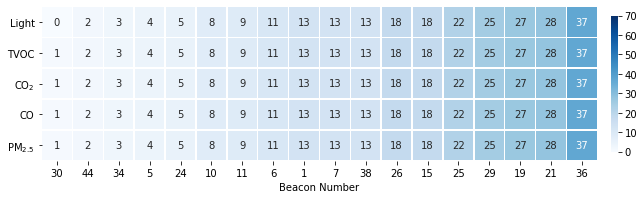

In [70]:
temp = plot_data_availability_heatmap(ieq_and_bw_sleep,agg_str="_median",save=False)

## Restfulness Scores
Restfulness scores lend themselves to some analysis on the concentrations by grouping by score

### Joyplots
We can construct some joyplots to get a sense of the data we have.

In [71]:
def plot_joyplot(df, pollutant_aggregate, by_var="restful", save=False, save_dir="../reports/figures/beacon_ema"):
    """Joyplot of pollutant aggregate profile for various restful scores"""
    c = df[by_var].value_counts().sort_index()
    new_labels = []
    for i, count in enumerate(c):
        new_labels.append(f"{i} ({count})")
    fig, axes = joyplot(data=df,by=by_var,column=pollutant_aggregate,
                kind='kde',overlap=1,ylim='own',grid="y",labels=[""]*len(c),alpha=1,linewidth=2,colormap=LinearSegmentedColormap.from_list("", ["white","cornflowerblue"]),figsize=(8,6))
    agg = pollutant_aggregate.split("_")[-1]
    axes[-1].set_xlabel(f"Nightly {pollutant_aggregate.split('_')[-1].title()} {visualize.get_pollutant_label(pollutant_aggregate.split(f'_{agg}')[0])} Concentration ({visualize.get_pollutant_units(pollutant_aggregate.split(f'_{agg}')[0])})", fontsize=18)
    for ax, label in zip(axes, new_labels):
        ax.set_ylabel(label, rotation=0, va="top", fontsize=14)
        ax.set_xlim(left=0)
        
    plt.xticks(fontsize=14)
    fig.text(-0.1,0.5,"Restful Score (n)", va="center",fontsize=18,rotation=90)
    if save:
        plt.savefig(f"{save_dir}/{pollutant_aggregate}-{by_var}-joyplot.pdf", bbox_inches="tight")
    plt.show()
    plt.close()

In [ ]:
for pollutant in ["co2","pm2p5_mass","no2","tvoc","co"]:
    plot_joyplot(ieq_and_bw_sleep, f"{pollutant}_median")

<div class="alert alert-block alert-success">
 
It looks like there is a relationship between the `restful` score and `co2` as well as `tvoc`. Rather than looking at the four scores, we could try lumping 0 and 1 together or just doing a positive/negative response.
    
</div>

### Analysis on Three-Point Scale
We can do some more interesting ANalaysis Of VAriance (ANOVA) on the three restfulness scores and see if there are significant differences between the distributions.

In [72]:
for pollutant in ["co2","pm2p5_mass","no2","tvoc","co"]:
    pollutant_df = ieq_and_bw_sleep[[f"{pollutant}_median","restful_three"]]
    pollutant_df.dropna(subset=["restful_three"],inplace=True)
    grps = pd.unique(pollutant_df["restful_three"].values)
    d_data = {grp:pollutant_df[f"{pollutant}_median"][pollutant_df["restful_three"] == grp] for grp in grps}
    f, p = stats.f_oneway(d_data[1],d_data[2],d_data[3])
    print(f"Standard Deviations of Distributions for {visualize.get_pollutant_label(pollutant)}")
    for key in d_data.keys():
        li = d_data[key]
        print("\t", np.std(li))

    m_comp = pairwise_tukeyhsd(endog=pollutant_df[f'{pollutant}_median'], groups=pollutant_df['restful_three'], alpha=0.05)
    print(m_comp)

Standard Deviations of Distributions for CO$_2$
	 388.92759300082867
	 348.21925635110995
	 361.91479611415286
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower    upper   reject
--------------------------------------------------------
   1.0    2.0 -157.5719 0.0448 -312.2569  -2.8868   True
   1.0    3.0 -206.9776 0.0109 -374.4995 -39.4556   True
   2.0    3.0  -49.4057 0.5982 -171.4305  72.6191  False
--------------------------------------------------------
Standard Deviations of Distributions for PM$_{2.5}$
	 8.37607011173978
	 8.066156314002463
	 6.92781744553562
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   1.0    2.0   3.3877 0.0516  -0.018 6.7935  False
   1.0    3.0    3.033   0.13 -0.6554 6.7213  False
   2.0    3.0  -0.3548    0.9 -3.0414 2.3319  False
---------------------------------------------------


KeyError: "['no2_median'] not in index"

<div class="alert alert-block alert-success">
 
Seems that there are significant differences for the `co2` and `co` concentration profiles between some restfulness scores. We can see better results if we consider only binary outputs for the `restful` score. 
    
</div>

### Binary Restfulness Scores
By using the binary restfulness scores, we can create distributions of pollutants based on positive and negative restulfness scores.

In [73]:
def plot_restful_violin(df_in, target="co2_median", save=False, save_dir="../reports/figures", subfolder="beacon_ema"):
    """Plots violin plots of concentration distributions for positive and negative restfulness scores"""
    df = df_in.copy()
    fig, ax = plt.subplots(figsize=(4,4))
    df["target"] = target
    violin_axes = sns.violinplot(x="target",y=target,hue="restful_binary",hue_order=["Negative","Positive"],split=True,palette=["white","seagreen"],data=df,ax=ax,cut=0,inner="quartile",)
    for loc in ["right","top","bottom"]:
        ax.spines[loc].set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.get_legend().remove()
    if target.split("_")[-1].lower() == "median":
        ax.set_ylabel(f"Nightly Median {visualize.get_pollutant_label(pollutant)} ({visualize.get_pollutant_units(pollutant)})",fontsize=18)
    else:
        ax.set_ylabel("Ventilation Rate (ACH)",fontsize=18)
    plt.yticks(fontsize=14)
    ax.legend(loc="center",bbox_to_anchor=(0.5,-0.1),title="Restful Response",ncol=2,frameon=False,title_fontsize=14,fontsize=12)

    low_vals = df[df["restful_binary"] == "Negative"]
    high_vals = df[df["restful_binary"] == "Positive"]
    _, p = stats.ttest_ind(low_vals[target],high_vals[target], equal_var=True)

    if p > 0:
        # Annotating with p-values
        xloc = ax.get_xticks()
        weight="bold" if p < 0.05 else "normal"
        val = round(p,3) if p > 0.001 else "< 0.001"
        ax.text(xloc,ax.get_ylim()[1],f"p: {val}",fontsize=12,ha="center",va="bottom",weight=weight)

    if save:
        plt.savefig(f"{save_dir}/{subfolder}/{target}-binary_restful-violin.pdf", bbox_inches="tight")
    plt.show()
    plt.close()

In [93]:
def plot_restful_violin_combined(df_in, sleep_metric="restful", targets=["tvoc","no2","co","co2","pm2p5_mass","temperature_c"], hues=["Negative","Positive"], save=False, save_dir="../reports/figures", subfolder="beacon_ema",**kwargs):
    """Plots violin plots of concentration distributions for positive and negative restfulness scores"""
    legend_fs = 22
    tick_fs = 24
    label_fs = 26
    title_fs = 32
    df = df_in.copy()
    #ttest_results = {}
    pvals = pd.DataFrame()
    fig, axes = plt.subplots(2,3,figsize=(15,8),gridspec_kw={"wspace":0.5})
    for target, ax in zip(targets,axes.flat):
        target = target+"_median"
        df["target"] = target
        violin_axes = sns.violinplot(x="target",y=target,hue=f"{sleep_metric}_binary",hue_order=hues,split=True,palette=["white","seagreen"],data=df,ax=ax,cut=0,inner=None,)
        for loc in ["right","top","bottom"]:
            ax.spines[loc].set_visible(False)
        ax.get_xaxis().set_visible(False)
        ax.get_legend().remove()
        ax.set_ylabel(f"{visualize.get_pollutant_label(target.split('_median')[0])} ({visualize.get_pollutant_units(target.split('_median')[0])})",fontsize=label_fs)
        ax.tick_params(labelsize=tick_fs)
        if "ticks" in kwargs.keys():
            ax.set_yticks(kwargs["ticks"][target.split('_median')[0]])
        #if target == "pm2p5_mass_median":
        #    if sleep_metric == "restful":
          #      ax.legend(loc="center",bbox_to_anchor=(0.5,-0.1),title=f"Restfulness Rating",ncol=2,frameon=False,title_fontsize=tick_fs,fontsize=legend_fs)
           # else:
            #    ax.legend(loc="center",bbox_to_anchor=(0.5,-0.1),title=f"Number of Awakenings",ncol=2,frameon=False,title_fontsize=tick_fs,fontsize=legend_fs)

        low_vals = df[df[f"{sleep_metric}_binary"] == hues[0]]
        high_vals = df[df[f"{sleep_metric}_binary"] == hues[1]]
        _, p = stats.ttest_ind(low_vals[target],high_vals[target], equal_var=True, nan_policy="omit")
        pvals = pvals.append(pd.DataFrame({"pollutant":[target],"low":[len(low_vals)],"high":[len(high_vals)],
                                               "mean_low":[np.nanmean(low_vals[target])],"mean_high":np.nanmean(high_vals[target]),"p_val":[p]}))
        
        if p > 0:
            # Annotating with p-values
            xloc = ax.get_xticks()
            weight="bold" if p < 0.05 else "normal"
            val = round(p,3) if p > 0.001 else "< 0.001"
            ax.text(xloc,ax.get_ylim()[1],f"p: {val}",fontsize=tick_fs,ha="center",va="bottom",weight=weight)

    if save:
        plt.savefig(f"{save_dir}/{subfolder}/all_ieq-binary_{sleep_metric}-violin.pdf", bbox_inches="tight")
        plt.savefig(f'../../papers/5eea5276044b790001ee5687/figures/all_ieq-binary_{sleep_metric}-violin.pdf',bbox_inches="tight")
    plt.show()
    plt.close()
    
    return pvals

#### Pollutant Concentration Profiles and Restfulness Scores
Here we look at the pollutant concentration profiles for `negative` and `positive` `restful` scores.

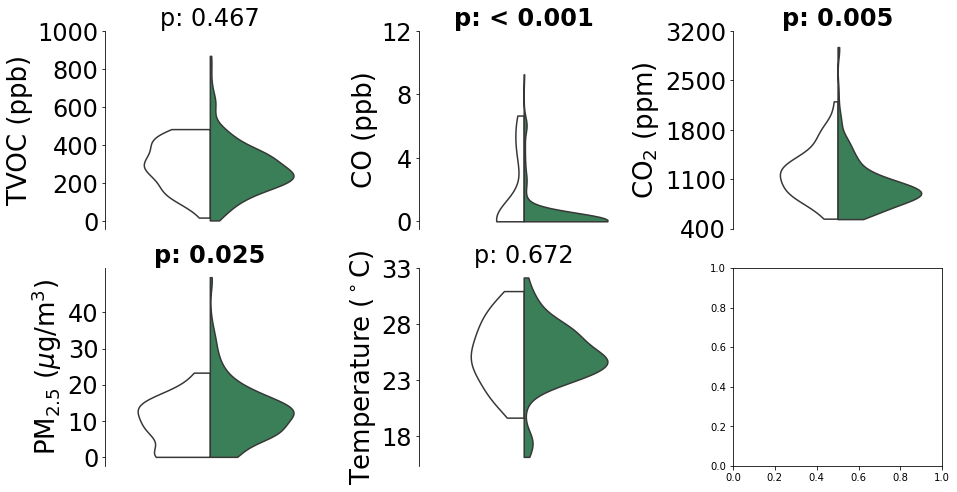

,pollutant,low,high,mean_low,mean_high,p_val
0,tvoc_median,41,216,293.630135,276.857867,0.467178
0,co_median,41,216,1.671728,0.491603,0.000029
0,co2_median,41,216,1191.225770,1016.393016,0.005258
0,pm2p5_mass_median,41,216,9.205152,12.283422,0.025231
0,temperature_c_median,41,216,25.444721,25.226375,0.671712


In [94]:
plot_restful_violin_combined(ieq_and_bw_sleep, targets=["tvoc","co","co2","pm2p5_mass","temperature_c"], 
                             ticks={"tvoc":range(0,1200,200),"co":range(0,16,4),"co2":range(400,3900,700),"pm2p5_mass":range(0,50,10),"temperature_c":range(18,35,5)},sleep_metric="restful", save=True)


In [91]:
high = ieq_and_bw_sleep[ieq_and_bw_sleep["restful_binary"] == "Positive"]
low = ieq_and_bw_sleep[ieq_and_bw_sleep["restful_binary"] == "Negative"]
print(f"Low:\t{len(low)}\nHigh:\t{len(high)}")

Low:	41
High:	216


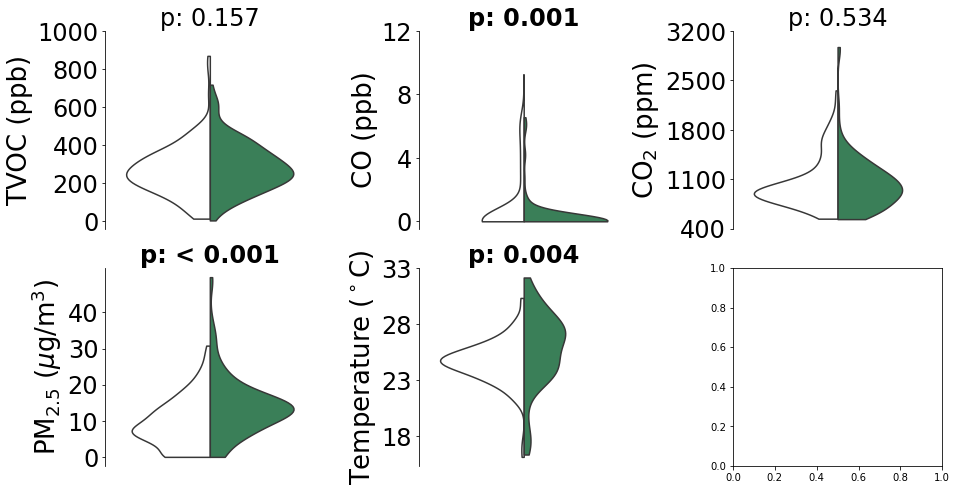

,pollutant,low,high,mean_low,mean_high,p_val
0,tvoc_median,121,136,266.867922,290.802325,0.156659
0,co_median,121,136,1.034949,0.363958,0.001278
0,co2_median,121,136,1059.518176,1030.731241,0.534030
0,pm2p5_mass_median,121,136,9.265249,14.040700,0.000001
0,temperature_c_median,121,136,24.674036,25.744199,0.003586


In [96]:
plot_restful_violin_combined(ieq_and_bw_sleep,targets=["tvoc","co","co2","pm2p5_mass","temperature_c"],sleep_metric="naw",hues=["High","Low"],
                             ticks={"tvoc":range(0,1200,200),"co":range(0,16,4),"co2":range(400,3900,700),"pm2p5_mass":range(0,50,10),"temperature_c":range(18,35,5)},
                             save=True)

In [78]:
high = ieq_and_bw_sleep[ieq_and_bw_sleep["naw_binary"] == "High"]
low = ieq_and_bw_sleep[ieq_and_bw_sleep["naw_binary"] == "Low"]
print(f"Low:\t{len(low)}\nHigh:\t{len(high)}")

Low:	136
High:	121


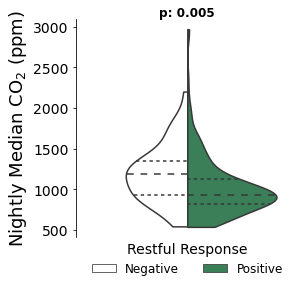

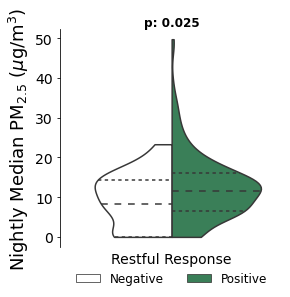

ValueError: Could not interpret input 'no2_median'

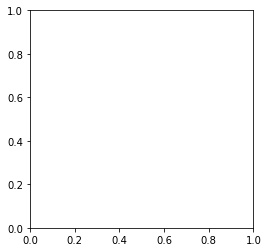

In [79]:
for pollutant in ["co2","pm2p5_mass","no2","tvoc","co","temperature_c"]:
    plot_restful_violin(ieq_and_bw_sleep, target=f"{pollutant}_median", save=False,)

#### Ventilation and Restfulness Scores
Similar to above, but now looking at `ach` for `negative` and `positive` `restful` scores.

In [ ]:
def plot_restful_swarm(df_in, feature="restful", target="co2_median", save=False, save_dir="../reports/figures", subfolder="beacon_ema"):
    """Plots violin plots of concentration distributions for positive and negative restfulness scores"""
    df = df_in.copy()
    # adding binary score
    df[f"{feature}_binary"] = ["Positive" if score > 1 else "Negative" for score in df[feature]]
    fig, ax = plt.subplots(figsize=(6,6))
    df["target"] = target
    violin_axes = sns.swarmplot(x="target",y=target,hue=f"{feature}_binary",hue_order=["Negative","Positive"],split=True,palette=["black","cornflowerblue"],size=10,data=df,ax=ax)
    for loc in ["right","top","bottom"]:
        ax.spines[loc].set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.get_legend().remove()
    if target.split("_")[-1].lower() == "median":
        ax.set_ylabel(f"Nightly Median {visualize.get_pollutant_label(pollutant)} Concentration ({visualize.get_pollutant_units(pollutant)})",fontsize=18)
    else:
        ax.set_ylabel("Ventilation Rate (ACH)",fontsize=18)
    plt.yticks(fontsize=14)
    ax.legend(loc="center",bbox_to_anchor=(0.5,-0.1),title=f"{feature.title()} Response",ncol=2,frameon=False,title_fontsize=14,fontsize=12)

    low_vals = df[df[f"{feature}_binary"] == "Negative"]
    high_vals = df[df[f"{feature}_binary"] == "Positive"]
    _, p = stats.ttest_ind(low_vals[target],high_vals[target], equal_var=True)

    if p > 0:
        # Annotating with p-values
        xloc = ax.get_xticks()
        weight="bold" if p < 0.05 else "normal"
        ax.text(xloc-0.07,ax.get_ylim()[1],"p: ",fontsize=12,ha="center",va="bottom")
        ax.text(xloc,ax.get_ylim()[1],f"{round(p,3)}",fontsize=12,ha="center",va="bottom",weight=weight)

    if save:
        plt.savefig(f"{save_dir}/{subfolder}/{target}-binary_{feature}-swarm.pdf", bbox_inches="tight")
    plt.show()
    plt.close()

In [ ]:
for likert in ["content","stress","energy","lonely","sad","restful"]:
    plot_restful_swarm(aer_and_bw, feature=likert, target="ach", save=False)

## Sleep Onset Latency

In [84]:
def plot_bw_sq_violins(df, pollutants=["tvoc","no2","co","co2","pm2p5_mass","temperature_c"], limits=[200,1.5,4,1100,6,25.2], sleep_device="fitbit", sleep_metrics=["tst","sol"], pollutant_metric="median", annot="all",save=False):
    """
    
    """
    legend_fs = 22
    tick_fs = 24
    label_fs = 26
    title_fs = 32
    df_to_plot = df.copy()
    # adding "low"/"high" column for each pollutant
    thresholds = dict(zip(pollutants,limits))
    for pollutant, threshold in thresholds.items():
        df_to_plot[f"{pollutant}_level"] = df_to_plot.apply(lambda x: get_night(x[f"{pollutant}_{pollutant_metric}"],threshold),axis=1)

    # creating dictionary to store p-values
    ttest_results = {}
    # looping through sleep metrics
    fig,axes = plt.subplots(len(sleep_metrics),1,figsize=(16,5*len(sleep_metrics)),sharex=True)
    try:
        _ = len(axes)
    except TypeError:
        axes = [axes]
    for sleep_metric, title, ax in zip(sleep_metrics,["a","b"],axes):
        # expanding the df to allow for easier plotting
        df_expanded = df_to_plot.melt(id_vars=[c for c in df_to_plot.columns if c.endswith("median") or c == sleep_metric],value_vars=[c for c in df_to_plot.columns if c.endswith("level")],value_name="level")
        # plotting
        sns.violinplot(x="variable",y=sleep_metric,hue="level",data=df_expanded,split=True,hue_order=["low","high"],palette={"low":"white","high":"#bf5700"},inner=None,cut=0,ax=ax)
        # x-axis
        ax.set_xticklabels([pollutant.split("_")[0].upper().replace("O2","O$_2$").replace("2P5","$_{2.5}$").replace(" C","").replace("TEMPERATURE","T") for pollutant in pollutants],fontsize=tick_fs)
        ax.set_xlabel("")
        # y-axis
        plt.setp(ax.get_yticklabels(), ha="right", rotation=0, fontsize=tick_fs)
        ax.set_ylabel(visualize.get_label(sleep_metric),fontsize=label_fs)
        # Modifying Remainder
        if sleep_metric == "sol":
            ax.legend(loc="upper center",bbox_to_anchor=(0.5,-0.075),frameon=False,ncol=2,fontsize=legend_fs,title_fontsize=tick_fs,title="Median Concentration")
        else:
            ax.get_legend().remove()
        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)
            
        ax.text(-0.075,0.95,title,fontsize=title_fs,transform=ax.transAxes)

        pvals = pd.DataFrame()
        for pollutant in pollutants:
            df = df_expanded[df_expanded["variable"] == f"{pollutant}_level"]
            low_vals = df[df["level"] == "low"]
            high_vals = df[df["level"] == "high"]
            _, p = stats.ttest_ind(low_vals[sleep_metric],high_vals[sleep_metric], equal_var=True, nan_policy="omit")
            pvals = pvals.append(pd.DataFrame({"pollutant":[pollutant],"low":[len(low_vals)],"high":[len(high_vals)],
                                               "mean_low":[np.nanmean(low_vals[sleep_metric])],"mean_high":np.nanmean(high_vals[sleep_metric]),"p_val":[p]}))

        ttest_results[sleep_metric.split("_")[0]] = pvals.set_index("pollutant")

        # Annotating with p-values
        xlocs = ax.get_xticks()
        ax.text(ax.get_xlim()[0],ax.get_ylim()[1],"          p:",ha="center",va="bottom",fontsize=tick_fs)
        for xloc, p in zip(xlocs,ttest_results[sleep_metric.split("_")[0]]["p_val"]):
            weight="bold" if p < 0.05 else "normal"
            val = round(p,3) if p > 0.001 else "< 0.001"
            ax.text(xloc,ax.get_ylim()[1],val,fontsize=tick_fs,ha="center",va="bottom",weight=weight)
            
        if save:
            plt.savefig(f'../../papers/5eea5276044b790001ee5687/figures/beacon-{sleep_device}-{pollutant_metric}_profile-{annot}-ux_s20.pdf',bbox_inches="tight")
            plt.savefig(f'../reports/figures/beacon_{sleep_device}/beacon-{sleep_device}-{pollutant_metric}_profile-{annot}-ux_s20.pdf',bbox_inches="tight")

    plt.show()
    plt.close()
    
    return ttest_results
    

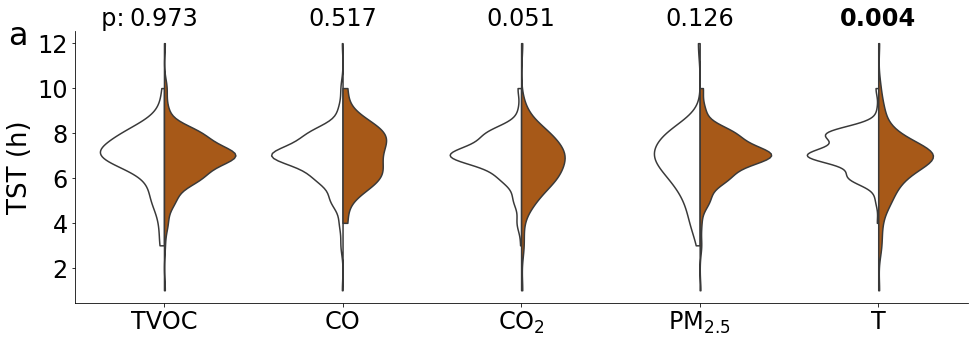

In [85]:
temp = plot_bw_sq_violins(ieq_and_bw_sleep, pollutants=["tvoc","co","co2","pm2p5_mass","temperature_c"], 
                          limits=[200,4,1100,6,25.2], sleep_metrics=["tst"], sleep_device="ema", annot="tst",save=True)


In [ ]:
(temp["tst"].loc["temperature_c","mean_low"] - temp["tst"].loc["temperature_c","mean_high"])*60

In [ ]:
def test_for_outlier(df, var, extreme="z",zscore=2.5):
    """checks values"""
    if extreme == "z":
        df['z'] = abs(df[var] - df[var].mean()) / df[var].std(ddof=0)
        df["outlier"] = df['z'] > zscore
    else:
        Q1 = df[var].quantile(0.25)
        Q3 = df[var].quantile(0.75)
        IQR = Q3 - Q1

        # Filtering Values between Q1-1.5IQR and Q3+1.5IQR
        df["outlier"] = (df[var]<Q1-1.5*IQR) | (df[var]>Q3+1.5*IQR)
        
    fig, ax = plt.subplots(figsize=(4,4))
    sns.stripplot(x="outlier",y=var,data=df,ax=ax)

In [ ]:
test_for_outlier(ieq_and_bw_sleep,"sol",extreme="z")